In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# from keras.backend import manual_variable_initialization manual_variable_initialization(True)

In [3]:
# Import required packages
from sklearn.metrics import accuracy_score, classification_report
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import dataread
import classifierutils
import logging
import random
import re

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize.regexp import regexp_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

"""Variables"""

# headers = ['allergies', 'family_history', 'history_illness', 'social_history']
headers = dataread.read_file('top_sectionheaders_50000 copy.txt')
no_sections = 5000

"""Import data"""

# header --> [header, original, tokenized, tokenized_labelled]
header_corpus = {}

for header in headers:
    header_corpus[header] = {}
    header_corpus[header]['label'] = header
    temp = dataread.read_file('section/'+header.replace(' ',
                                                        '_')+str(no_sections)+'.txt')
    new = []
    for sample in temp:
        kek = re.sub("\[.*?\]", "", sample)
        new.append(kek)

    header_corpus[header]['original'] = pd.Series(
        new
    )
    temp = classifierutils.corpus_preprocess(
        header_corpus[header]['original'],
        header
    )
    header_corpus[header]['labelled'] = temp[0]
    header_corpus[header]['labelled_tokenised'] = temp[1]

mixed_labelled = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled = mixed_labelled.append(value['labelled'])

mixed_labelled_tokenised = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled_tokenised = mixed_labelled_tokenised.append(
        value['labelled_tokenised'])

mixed_labelled = shuffle(mixed_labelled)

'Variables'

'Import data'

In [4]:
mixed_labelled.head()

,TEXT,HEADER
289,aspirin mg tablet delayed release e c sig one ...,discharge medications
3294,patient year old female recent admission colon...,history of present illness
2181,none,major surgical or invasive procedure
1544,coumadin mg every day except mg friday diltiaz...,medications on admission
2229,incarcerated paraesophageal hernia,chief complaint


In [5]:
mixed_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44633 entries, 289 to 1061
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    44633 non-null  object
 1   HEADER  44633 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [6]:
mixed_labelled.HEADER.value_counts()

history of present illness              4707
past medical history                    4674
allergies                               4556
social history                          4302
discharge medications                   4080
medications on admission                3947
chief complaint                         3854
family history                          3853
discharge disposition                   3593
brief hospital course                   3541
major surgical or invasive procedure    3526
Name: HEADER, dtype: int64

In [7]:
mixed_labelled['HEADER'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Samples', 
                                                                title='Number of samples in each section header')

In [8]:
def print_plot(index):
    example = mixed_labelled[mixed_labelled.index == index][['TEXT', 'HEADER']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [9]:
print_plot(10)

chest pain vessel disease catheterization
Product: chief complaint


In [10]:
print_plot(3000)

normal mibi though echo shows small area akinesis htn hld dm copd emphysema gerd barrett esophagus elevated psa p normal biopsy childhood seizure disorder last event years age anxiety trouble anger management risperdal learning disability multiple hernias glaucoma bilaterally strabismus tonsillectomy umbilical hernia repair right inguinal hernia repair eye operation years age seeing double
Product: past medical history


In [11]:
mixed_labelled = mixed_labelled.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].apply(clean_text)

In [12]:
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].str.replace('\d+', '')

In [13]:
print_plot(10)

lives retired business man etoh smoking drug
Product: social history


In [14]:
print_plot(100)

f presented osh progressive lower etremity weakness pod c l fusion early pt severe thoracic spine pain lifting lb pain described sharp pain radiating bilaterally anteriorly band like fashion breasts pt took ibuprofen pain later took hydrocodone made nauseous pt noted rubbery legs unable walk bladder bowel intact went osh ct scan revealed l compression fractures thoracic spinal cord compression subsequently transferred pt noted mild lower etremity weakness sensory loss bilateral upgoing babinski mri showed pathologic compression fracture diffusely abnormal signal intensity involving vertebral body pedicles laminae also noted severe spinal cord compression epidural soft tissue component also prevertebral soft tissue component several scattered lesions increased signal intensity spine including sacrum representing metastatic lesions pt underwent fusion c l vertebrae b lymph node sent immunophenotyping pathology pt subsequent sent tsicu care following laminectomy received ml lr ml prbcs eb

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(mixed_labelled['TEXT'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28689 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(mixed_labelled['TEXT'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44633, 250)


In [17]:
Y = pd.get_dummies(mixed_labelled['HEADER']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (44633, 11)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(40169, 250) (40169, 11)
(4464, 250) (4464, 11)


In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
epochs = 2
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
565/565 [==============================] - 484s 857ms/step - loss: 0.7542 - accuracy: 0.7598 - val_loss: 0.3272 - val_accuracy: 0.9044
Epoch 2/2
565/565 [==============================] - 472s 836ms/step - loss: 0.2782 - accuracy: 0.9126 - val_loss: 0.2779 - val_accuracy: 0.9136


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

140/140 [==============================] - 9s 65ms/step - loss: 0.2713 - accuracy: 0.9131
Test set
  Loss: 0.271
  Accuracy: 0.913


In [36]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(Y_test)
# print(classification_report(Y_test, y_pred_bool))

70/70 [==============================] - 4s 62ms/step
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [53]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(Y_test, axis=1)

print(classification_report(y_test, y_pred_bool, target_names=sorted(headers)))

70/70 [==============================] - 4s 63ms/step
                                      precision    recall  f1-score   support

                           allergies       0.97      0.96      0.97       432
               brief hospital course       0.89      0.88      0.88       366
                     chief complaint       0.94      0.94      0.94       399
               discharge disposition       0.98      0.99      0.99       347
               discharge medications       0.90      0.84      0.87       412
                      family history       0.95      0.93      0.94       423
          history of present illness       0.96      0.87      0.91       472
major surgical or invasive procedure       0.92      0.96      0.94       366
            medications on admission       0.88      0.83      0.85       407
                past medical history       0.97      0.89      0.93       444
                      social history       0.74      0.98      0.84       396

        

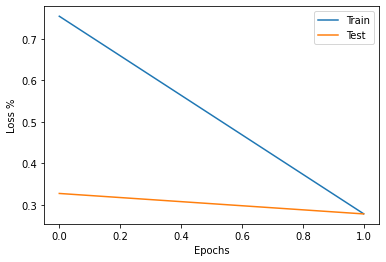

In [49]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss %')
plt.legend()
plt.show();

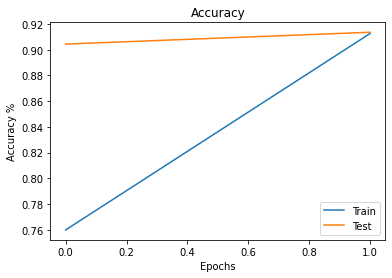

In [50]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.show();

In [28]:
new_complaint = ["""No Known Drug Allergies"""]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = sorted(headers)
print(labels)
print(pred, labels[np.argmax(pred)])

['allergies', 'brief hospital course', 'chief complaint', 'discharge disposition', 'discharge medications', 'family history', 'history of present illness', 'major surgical or invasive procedure', 'medications on admission', 'past medical history', 'social history']
[[9.9993014e-01 1.2968433e-06 2.4342391e-05 1.5405470e-07 2.1022440e-06
  7.2233534e-06 1.7828892e-06 7.3671771e-08 9.9364124e-06 1.4214168e-05
  8.7258832e-06]] allergies


In [25]:
model.save('model/LTSM_RNN_2EP_91.h5')
model.save_weights('model/LTSM_RNN_2EP_91_w.h5')

In [30]:
import dataclass
import importlib
dataclass = importlib.reload(dataclass)
samples = pd.DataFrame()
for value in header_corpus.values():
    samples = samples.append(value['labelled'])

data = dataread.read_samples(2)
data_class = []
for item in data:
    data_class.append(
        dataclass.Sample(item)
    )

labels = sorted(headers)

for item in data_class:
    item.paragraph_classify(model, tokenizer, labels)

export = []
for item in data_class:
    item.paragraph_classify_indexed()
    export.append(item.paragraph_classifed_print())

dataread.save_array(export, 'test2.txt')
    

# labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

# corpus = []
# for()


1.0000000819563866 11
1.0000000361760613 11
0.9999999552965164 11
0.9999999312130967 11
1.000000023515895 11
0.9999999683059286 11
1.0000000009313226 11
1.0000000345753506 11
1.0000000819563866 11
1.0000000325635483 11
0.9999999674037099 11
0.9999999487190507 11
1.000000023515895 11
1.0000000986619852 11
0.9999999227329681 11
0.9999999866668077 11
1.000000013911631 11
1.000000086869676 11
1.0000000268411213 11
1.0000000952277333 11
0.9999999511055648 11
0.9999999728461262 11
1.0000000037252903 11
1.0000000433064997 11
0.9999999894062057 11
1.000000020256266 11
1.0000000409781933 11
1.0000001434236765 11
0.999999990221113 11
0.999999932013452 11
0.9999999903375283 11
1.0000000344589353 11
0.9999999767169356 11
1.0000000599538907 11
1.0000000273576006 11
1.0000000046566129 11
0.9999999104766175 11
1.0000000754371285 11
0.9999999199062586 11
0.9999999300343916 11
1.0000001097796485 11
1.0000000861473382 11
1.0000000167638063 11
0.9999999739375198 11
0.9999999867650331 11
0.999999881838448

In [27]:
# from keras.models import load_model

# model = load_model('model/LTSM_RNN.h5')

In [31]:
# Saved Model

import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tf.saved_model.save(model, 'model/alpha/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/alpha/assets
